In [5]:
import mne
import scipy
import numpy as np
import matplotlib.pyplot as plt
import utils
import os
import glob
from scipy.stats import zscore, pearsonr
from scipy.io import savemat, loadmat
from scipy import signal
%matplotlib widget

In [10]:
%%capture
subjects = ['AS', 'YY']
folder = 'EOG'
# videos = ['Dr', 'Parra', 'Safety', 'Spring']
videos = ['Dr']
feature_type = 'muFlow'
features_list = []
eeg_multisub_list = []
for video in videos:
    features, eeg_multisub, fs, _ = utils.multisub_data_org(subjects, video, folder, feature_type=feature_type, bads=['B25'], eog=True, regression=False)
    features_list.append(features)
    eeg_multisub_list.append(eeg_multisub)
feature_concat = np.concatenate(tuple(features_list), axis=0)
eeg_multisub_concat = np.concatenate(tuple(eeg_multisub_list), axis=0)
T = feature_concat.shape[0]
times = np.array(range(T))/fs

In [3]:
eeg_onesub = eeg_multisub_concat[:,:,0]

In [4]:
eeg_seg = eeg_onesub[:30,:]

In [12]:
np.mean(eeg_seg, axis=1)

array([ 1.30104261e-18,  8.67361738e-19,  1.39048929e-17,  1.74285499e-17,
       -2.99917426e-17, -1.81061763e-17, -7.02020907e-18,  1.02999206e-17,
        1.19262239e-18,  7.15573434e-18,  1.16551734e-18,  1.49077799e-18,
       -1.43927838e-17,  5.42101086e-20, -1.23666810e-19,  1.78215732e-18,
        3.25260652e-19, -3.07642366e-18,  6.50521303e-19,  8.17217388e-18,
        2.49366500e-18,  1.02999206e-18,  4.11996826e-18,  7.58941521e-19,
       -1.08420217e-18, -3.33392168e-18, -1.39591030e-18, -3.19839641e-18,
        1.57209315e-18,  8.67361738e-19])

In [5]:
np.trace(eeg_seg.T@eeg_seg)

1.0000000000000004

In [22]:
np.trace((eeg_seg-np.mean(eeg_seg, axis=0)).T@(eeg_seg-np.mean(eeg_seg, axis=0)))/29

0.03448275862068966

In [24]:
np.trace(np.cov(eeg_multisub_concat[:,:,1], rowvar=False))

0.03340920634323445

In [26]:
conv_mtx = utils.convolution_mtx(30, feature_concat)

In [29]:
np.trace(np.cov(conv_mtx, rowvar=False))

0.0020806647449647313

In [12]:
L_timefilter = int(fs)
n_components = 5
fold = 10
eeg_onesub = eeg_multisub_concat[:,:,0]
# GCCA-one subject + stimulus = CCA
rhos = [1, 1]
# corr_train, corr_test, Wlist = utils.cross_val_GCCA_multi_mod([eeg_onesub, feature_concat], L_timefilter, rhos, fold, n_components, regularizaion='lwcov')
corr_train, corr_test, V_A_train, V_B_train = utils.cross_val_CCA(eeg_onesub, feature_concat, L_timefilter, fold, n_components, regularizaion='lwcov', K_regu=None)


Average correlation coefficients of the top 5 components on the training sets: [0.24165035 0.17770294 0.14852457 0.10856077 0.1007487 ]
Average correlation coefficients of the top 5 components on the test sets: [ 0.15223497  0.01217448  0.05065851 -0.00592924  0.03465337]


Average correlation coefficients of the top 5 components on the training sets: [0.17925619 0.11126491 0.0813105  0.06266028 0.05242931]
Average correlation coefficients of the top 5 components on the test sets: [0.15094888 0.04085075 0.02920622 0.01177677 0.01330744]

correlation coefficient = [ 0.00881208 -0.00742599 -0.00969502 -0.00137581 -0.01220427], p-value = [0.56860151 0.63091839 0.53050305 0.92907477 0.4297673 ]%


100%|██████████| 1000/1000 [00:04<00:00, 215.75it/s]


Component 1, top 34.0%


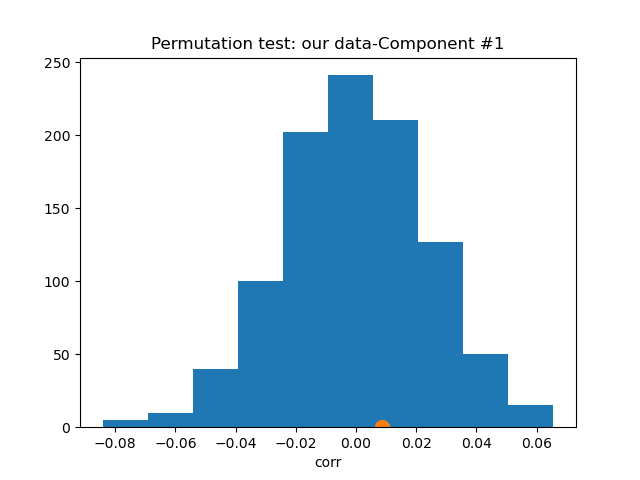

In [4]:
# Permutation test
fold = 5
idx = 4
EEG_train, EEG_test, Sti_train, Sti_test = utils.split(eeg_onesub, feature_concat, fold=fold, fold_idx=idx+1)
conv_mtx_train = utils.convolution_mtx(L_timefilter, Sti_train)
corr_train, _, V_A_train, V_B_train = utils.cano_corr(EEG_train, conv_mtx_train, n_components=n_components, regularizaion='lwcov')
conv_mtx_test = utils.convolution_mtx(L_timefilter, Sti_test)
corr_test, p_value_test, _, _ = utils.cano_corr(EEG_test, conv_mtx_test, n_components=n_components, V_A=V_A_train, V_B=V_B_train, regularizaion='lwcov')
print("correlation coefficient = {}, p-value = {}%".format(corr_test, p_value_test))
num_test=1000
corr_coe_topK = utils.permutation_test(EEG_test, np.squeeze(Sti_test, axis=1), num_test, t=1, fs=fs, topK=n_components, V_A=V_A_train, V_B=V_B_train)

compo = 1
corr_coe_list = corr_coe_topK[:,compo-1]
signifi = sum(corr_coe_topK[:,compo-1]>corr_test[compo-1])/num_test*100
print("Component {compo}, top {signifi}%".format(compo=compo, signifi=signifi))
plt.close()
plt.hist(corr_coe_topK[:,compo-1])
plt.title('Permutation test: our data-'+'Component #'+str(compo))
plt.xlabel('corr')
plt.plot(corr_test[compo-1], 0, marker="o", markersize=10)
plt.show()

In [5]:
np.sort(abs(corr_coe_topK[:,0]))

array([6.45395223e-05, 1.45461757e-04, 1.57400142e-04, 2.82883342e-04,
       2.99573478e-04, 3.14877615e-04, 3.57821915e-04, 3.96059218e-04,
       4.61080346e-04, 4.76815731e-04, 4.78543090e-04, 4.81532757e-04,
       5.54699070e-04, 5.59094760e-04, 5.66770718e-04, 5.83086486e-04,
       5.85589560e-04, 5.94217738e-04, 6.83177463e-04, 7.40217732e-04,
       7.44785588e-04, 7.45388182e-04, 8.58794451e-04, 8.84740352e-04,
       9.63468899e-04, 9.63626916e-04, 9.69086647e-04, 1.00669205e-03,
       1.01424765e-03, 1.03941611e-03, 1.04424450e-03, 1.06580081e-03,
       1.09060538e-03, 1.10901309e-03, 1.14287775e-03, 1.17520017e-03,
       1.20944472e-03, 1.23293409e-03, 1.26707896e-03, 1.27719519e-03,
       1.27945142e-03, 1.28562833e-03, 1.29454214e-03, 1.34016728e-03,
       1.35556796e-03, 1.36764077e-03, 1.39960549e-03, 1.41407581e-03,
       1.48761161e-03, 1.49378602e-03, 1.50258973e-03, 1.54166204e-03,
       1.55114264e-03, 1.57068458e-03, 1.57124064e-03, 1.58278239e-03,
      

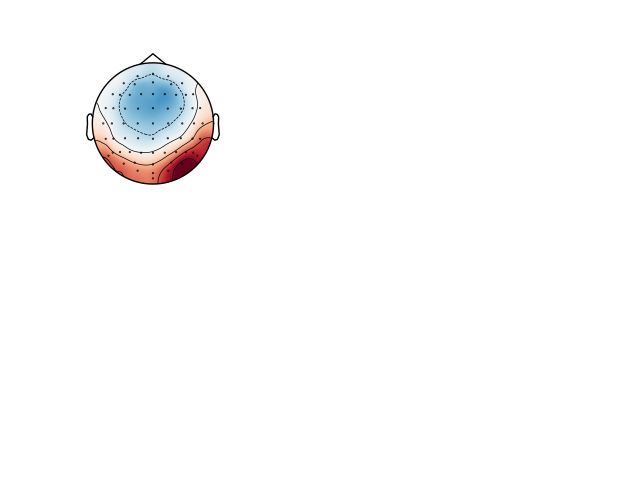

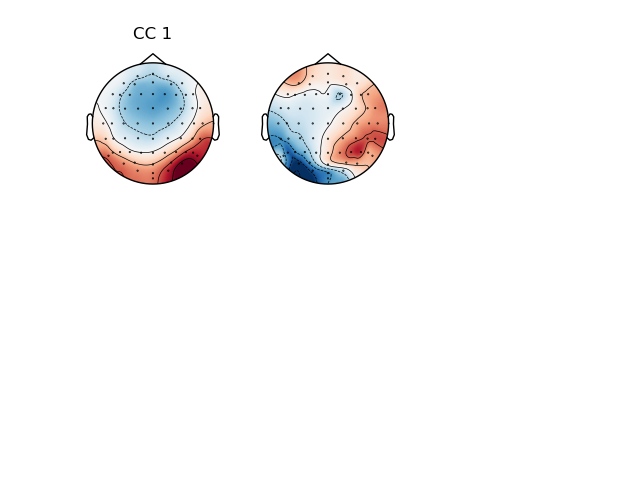

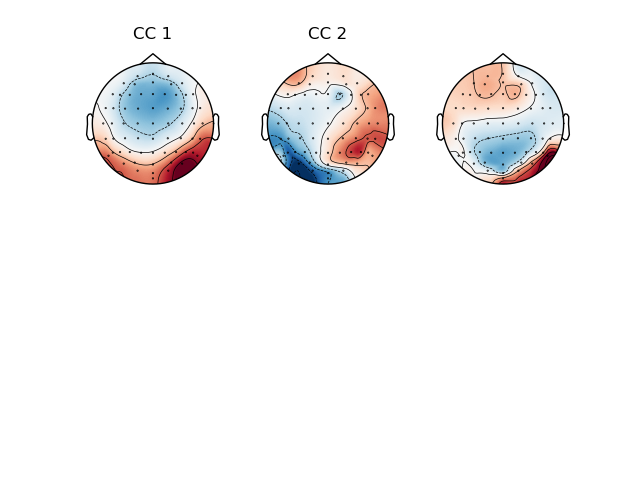

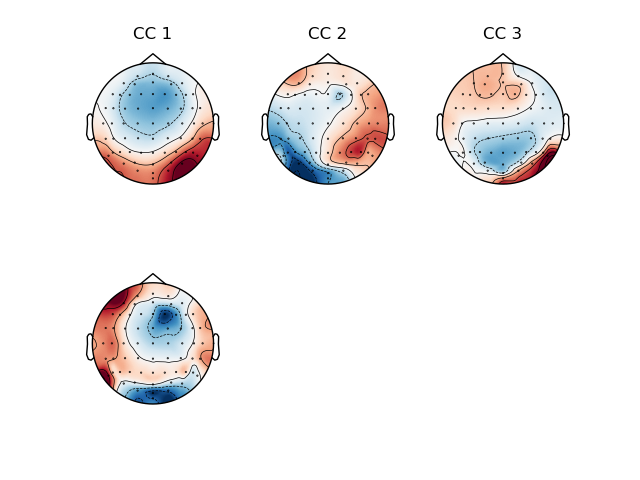

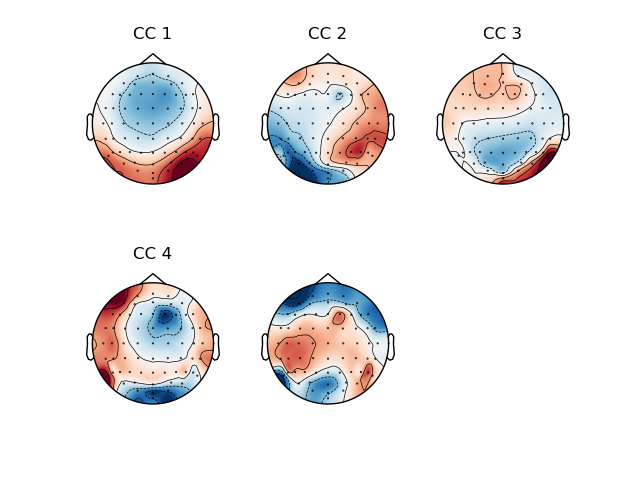

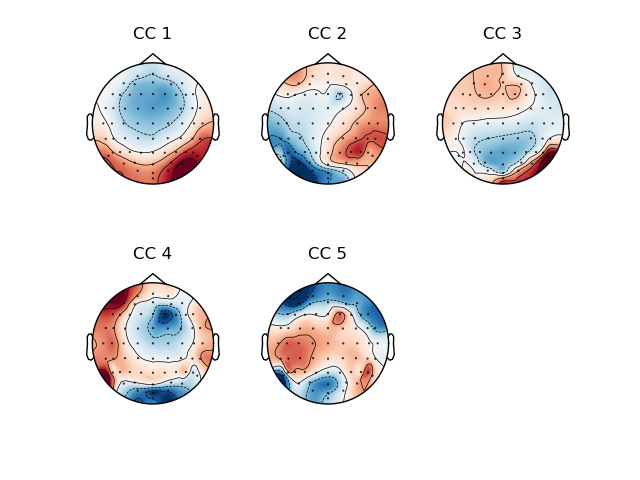

In [10]:
# Visualization:
forward_model = utils.forward_model(eeg_onesub, V_A_train, regularization=None)
biosemi_layout = mne.channels.read_layout('biosemi')
create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=30)
create_info.set_montage('biosemi64')
plt.close()
plt.figure()
# plt.figure(figsize=(20, 20))
for i in range(5):
    ax = plt.subplot(2, 3, i + 1)
    mne.viz.plot_topomap(forward_model[:,i], create_info, ch_type='eeg', axes=ax)
    ax.set_title('CC '+str(i+1))
plt.show()

In [9]:
# GCCA-all subjects
rhos = [1]
corr_train, corr_test, Wlist = utils.cross_val_GCCA_multi_mod([eeg_multisub_concat], L_timefilter, rhos, fold, n_components, regularizaion='lwcov')

Average correlation coefficients of the top 5 components on the training sets: [0.18072937 0.16901064 0.16328629 0.15869548 0.15240725]
Average correlation coefficients of the top 5 components on the test sets: [ 0.04482537 -0.00104464  0.00574224  0.02473269  0.00427319]


In [6]:
# GCCA-all subjects + stimulus
rhos = [1, 1]
corr_train, corr_test, Wlist = utils.cross_val_GCCA_multi_mod([eeg_multisub_concat, feature_concat], L_timefilter, rhos, fold, n_components, regularizaion='lwcov')

Average correlation coefficients of the top 5 components on the training sets: [0.02640135 0.02532788 0.02442602 0.03057459 0.02162716]
Average correlation coefficients of the top 5 components on the test sets: [ 4.18246179e-03  1.07107572e-02 -7.88376492e-05  1.56392004e-02
 -5.61538141e-03]


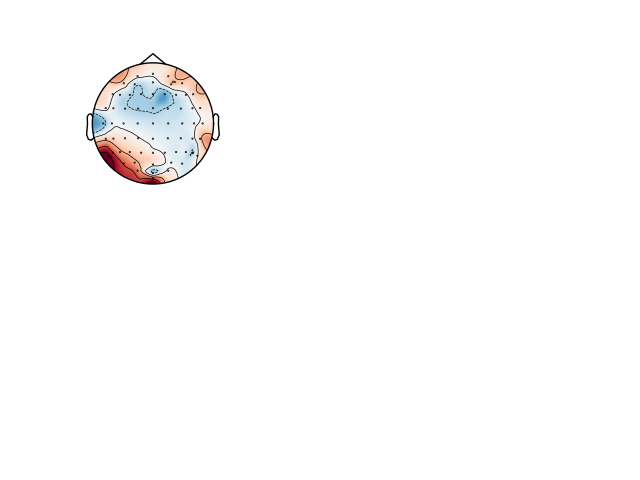

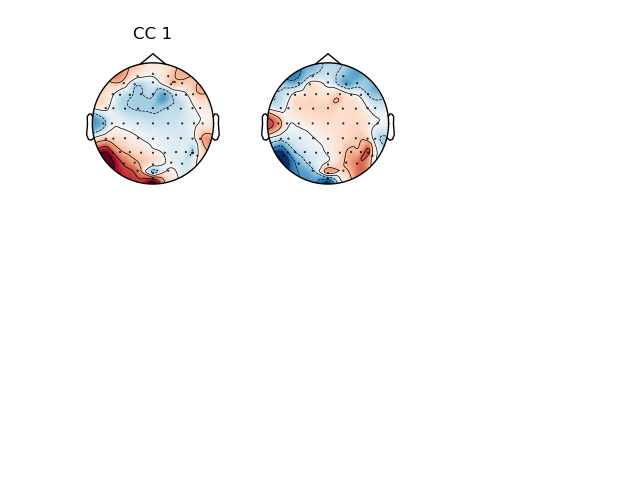

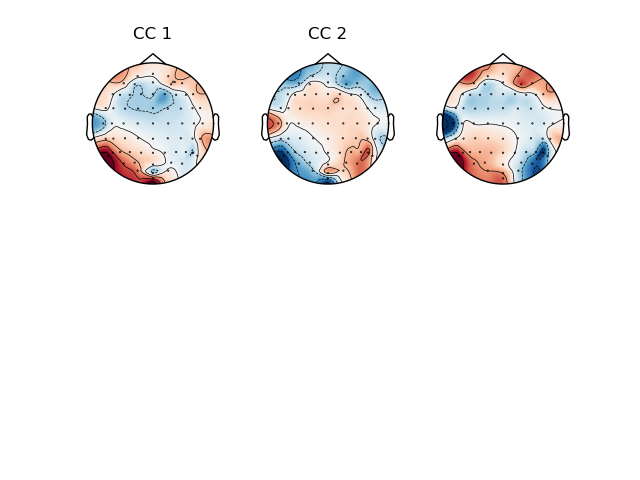

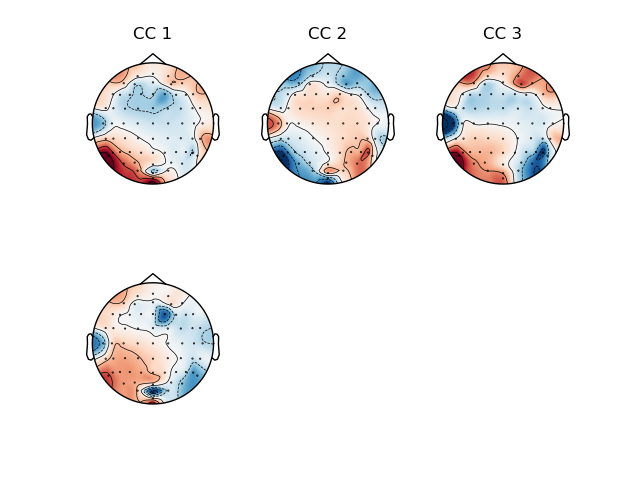

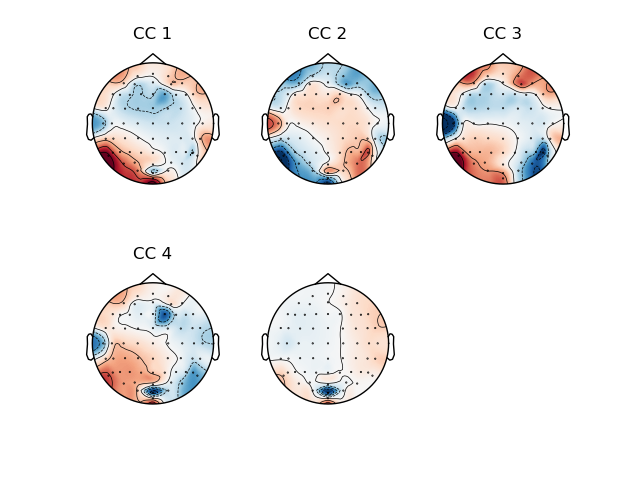

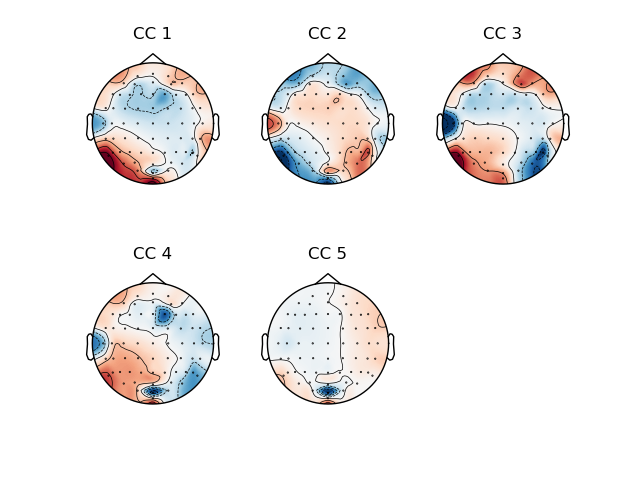

In [5]:
# Visualization:
forward_model = utils.forward_model(eeg_multisub_concat[:,:,0], Wlist[0][:,0,:], regularization=None)
biosemi_layout = mne.channels.read_layout('biosemi')
create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=30)
create_info.set_montage('biosemi64')
plt.close()
plt.figure()
# plt.figure(figsize=(20, 20))
for i in range(5):
    ax = plt.subplot(2, 3, i + 1)
    mne.viz.plot_topomap(forward_model[:,i], create_info, ch_type='eeg', axes=ax)
    ax.set_title('CC '+str(i+1))
plt.show()

In [ ]:
# Search for best rho
sweep_list = np.linspace(-3,3,13) # 10^{-3}, 10^{-2.5}, ..., 10^{3}
for i in sweep_list:
    rhos = [1, 10**i]
    corr_train, corr_test, Wlist = utils.cross_val_GCCA_multi_mod([eeg_multisub_concat, feature_concat], L_timefilter, rhos, fold, n_components, regularizaion='lwcov')
    print('ISC of the top {} components on the test sets when rho=10^{}: {}'.format(n_components, i, np.average(corr_test, axis=0)))


correlation coefficient = [ 0.00045325  0.00162719  0.00391887 -0.00280992 -0.01242902]


100%|██████████| 1000/1000 [02:11<00:00,  7.61it/s]

Component 1, top 44.2%


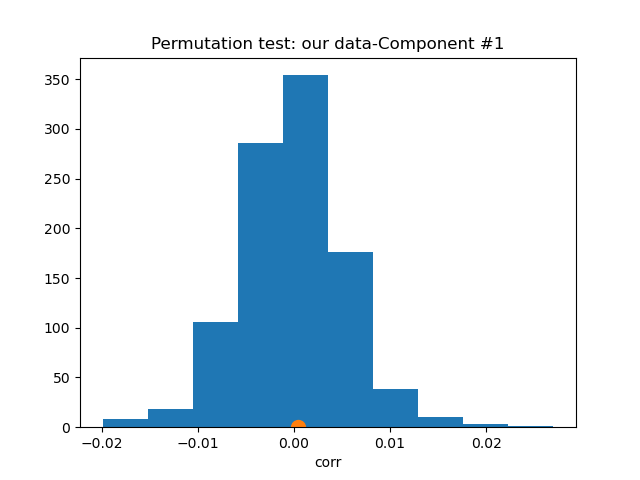

In [7]:
# Permutation test
from tqdm import tqdm
fold = 5
idx = 3
rhos = [1, 1]
len_test = T // fold
X_test = eeg_multisub_concat[len_test*idx:len_test*(idx+1),:,:]
X_train = np.delete(eeg_multisub_concat, range(len_test*idx, len_test*(idx+1)), axis=0)
Y_test = feature_concat[len_test*idx:len_test*(idx+1),:]
Y_train = np.delete(feature_concat, range(len_test*idx, len_test*(idx+1)), axis=0)

Wlist_train = utils.GCCA_multi_modal([X_train, Y_train], n_components, rhos, regularization='lwcov')
corr_train = utils.avg_corr_coe_multi_modal([X_train, Y_train], Wlist_train, n_components)
corr_test = utils.avg_corr_coe_multi_modal([X_test, Y_test], Wlist_train, n_components)
print("correlation coefficient = {}".format(corr_test))

num_test=1000
corr_shuffle = np.zeros((num_test, n_components))
for i in tqdm(range(num_test)):
    X_test = utils.shuffle_block(X_test, t=1, fs=30)
    Y_test = utils.shuffle_block(np.expand_dims(Y_test, axis=2), t=1, fs=30)
    Y_test = np.squeeze(Y_test, axis=2)
    Wlist_shuffle = utils.GCCA_multi_modal([X_test,Y_test], n_components, rhos, regularization='lwcov')
    corr_shuffle[i,:] = utils.avg_corr_coe_multi_modal([X_test,Y_test], Wlist_train, n_components)

compo = 1
signifi = sum(corr_shuffle[:,compo-1]>corr_test[compo-1])/num_test*100
print("Component {compo}, top {signifi}%".format(compo=compo, signifi=signifi))
plt.close()
plt.hist(corr_shuffle[:,compo-1])
plt.title('Permutation test: our data-'+'Component #'+str(compo))
plt.xlabel('corr')
plt.plot(corr_test[compo-1], 0, marker="o", markersize=10)
plt.show()

In [8]:
corr_shuffle[:,0]

array([ 1.99664373e-02,  5.93217541e-03, -1.11454868e-02,  3.67795634e-03,
       -3.96747544e-03, -7.58629692e-03,  2.70023480e-02,  4.54657533e-03,
       -2.01947207e-03, -1.92292792e-03,  6.95008875e-03, -7.24134894e-03,
        1.51102198e-02,  4.01893762e-03, -1.48365714e-03, -8.69677390e-03,
        1.65194333e-03, -3.84287068e-03,  8.44576858e-03, -1.67986021e-02,
       -1.29299564e-02,  2.20255301e-03,  5.84747974e-03, -4.13022778e-03,
        1.30205879e-03, -7.03776055e-03,  1.34663051e-02,  1.46844414e-02,
       -8.13675145e-03,  1.86926642e-02, -8.20445957e-03, -3.88084827e-03,
       -3.51039342e-03,  1.07257872e-02,  1.13249622e-02,  6.36124152e-03,
       -2.23873933e-03,  1.70936609e-03,  7.81315651e-03, -4.62756323e-03,
       -4.04255741e-04,  4.06551740e-03, -4.16528562e-03,  4.52127720e-03,
        1.63088916e-03,  1.34420434e-03,  1.96706277e-02,  4.76022484e-03,
        8.73725618e-03,  5.58188207e-03, -2.13707046e-03, -1.21564244e-02,
        3.48308778e-04,  

In [9]:
np.sort(abs(corr_shuffle[:,0]))

array([8.32172897e-07, 1.11472411e-05, 1.28322520e-05, 1.49384384e-05,
       2.24301653e-05, 3.30606179e-05, 4.18390932e-05, 4.28654858e-05,
       5.71270944e-05, 6.59527487e-05, 6.73825413e-05, 7.82399221e-05,
       7.98802011e-05, 8.34589871e-05, 9.06872211e-05, 1.20550002e-04,
       1.20632638e-04, 1.30946575e-04, 1.36049346e-04, 1.36462682e-04,
       1.37651327e-04, 1.42903174e-04, 1.51104062e-04, 1.63335141e-04,
       1.67266327e-04, 1.72609096e-04, 1.82555485e-04, 1.90823021e-04,
       1.98915866e-04, 2.03162763e-04, 2.03176291e-04, 2.10916805e-04,
       2.11445234e-04, 2.12940940e-04, 2.15676572e-04, 2.18086688e-04,
       2.33130914e-04, 2.37517072e-04, 2.40176416e-04, 2.49514441e-04,
       2.53403834e-04, 2.61557578e-04, 2.62699731e-04, 2.66195762e-04,
       2.66332385e-04, 2.68703391e-04, 2.76593831e-04, 2.77317454e-04,
       2.90878295e-04, 2.97519621e-04, 3.00188724e-04, 3.01890364e-04,
       3.09726226e-04, 3.22092382e-04, 3.26019435e-04, 3.28745947e-04,
      